## Walk Through Example PCA & Naive Bayes

(molecule data set)

As with the artificial dataset, we first want to walk through the analysis pipeline, which performs the following steps:<br> 
<br>
1) Loading the molecule data set *"molecular_test_gbc.xlsx"* and *"molecular_train_gbc.xlsx"*<br>
2) Creating a plot showing Pearsons' correlation of all features in *"molecular_train_gbc.xlsx"* in a heatmap and a UMAP plot<br>
3) Scaling and normalizing the dataset, before running a PCA<br>
4) Finally using NaiveBayes for classification<br>  

<br>

**0) Loading libraries**

We load our standard libraries:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Another useful tool to map high dimensional data into a 2D or 3D plot is UMAP (see office hour if interested into details). 

In [4]:
import umap.umap_ as umap

Finally, we import the libraries needed for performing Naive Bayes, PCA and normalization of the dataset.  

In [6]:
from sklearn.naive_bayes import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

<br>

**1) Reading the data set**

We read the training dataset for training the model, the test dataset for evaluating model performance and separate the features *X* and the labels *Y*.

In [8]:
Train  = pd.read_csv('molecular_train_gbc.csv')
TrainY = Train['label']
TrainX = Train.drop('label', axis = 1)

Test   = pd.read_csv('molecular_test_gbc.csv')
TestY  = Test['label']
TestX  = Test.drop('label', axis = 1)

In [10]:
Train.head()

molecular_weight  electronegativity  bond_lengths  num_hydrogen_bonds  \
0        382.601612           2.002692      3.611534                   3   
1        408.961459           2.936255      3.479041                   6   
2        239.547546           2.714128      2.639224                   8   
3        315.580280           2.855984      2.860342                   9   
4        282.521474           2.838770      2.966401                   1   

       logP      label  
0  9.826662      Toxic  
1  9.858888      Toxic  
2  6.759616  Non-Toxic  
3  8.706740  Non-Toxic  
4  7.817298  Non-Toxic

In [12]:
Test.head()

molecular_weight  electronegativity  bond_lengths  num_hydrogen_bonds  \
0        341.704142           2.655846      3.094069                   2   
1        335.950798           3.222621      2.890393                   7   
2        235.203185           2.441153      2.482026                   1   
3        246.504930           2.766560      2.715472                   7   
4        437.938926           3.480105      3.595688                   3   

        logP  label  
0   9.111473  Toxic  
1   8.928483  Toxic  
2   6.497307  Toxic  
3   7.450888  Toxic  
4  10.915629  Toxic

<br>

**2) Plotting the data set**

Since we have a dataset with five features, an ordinary 3D plot is not possible. However, we still can plot the correlation values. We also want to plot each feature against eachother.

2a) Pearsons Correlation Coefficient 

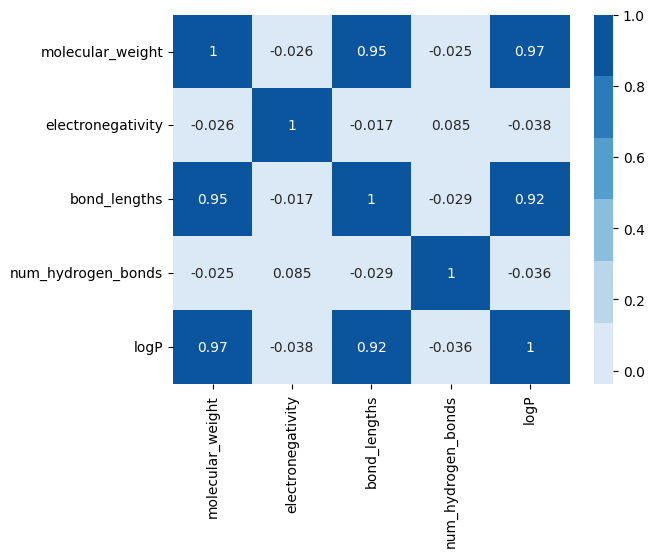

In [14]:
sns.heatmap(TrainX.corr(), annot=True, cmap = sns.color_palette("Blues"))
plt.show()

2b) Each feature vs eachother

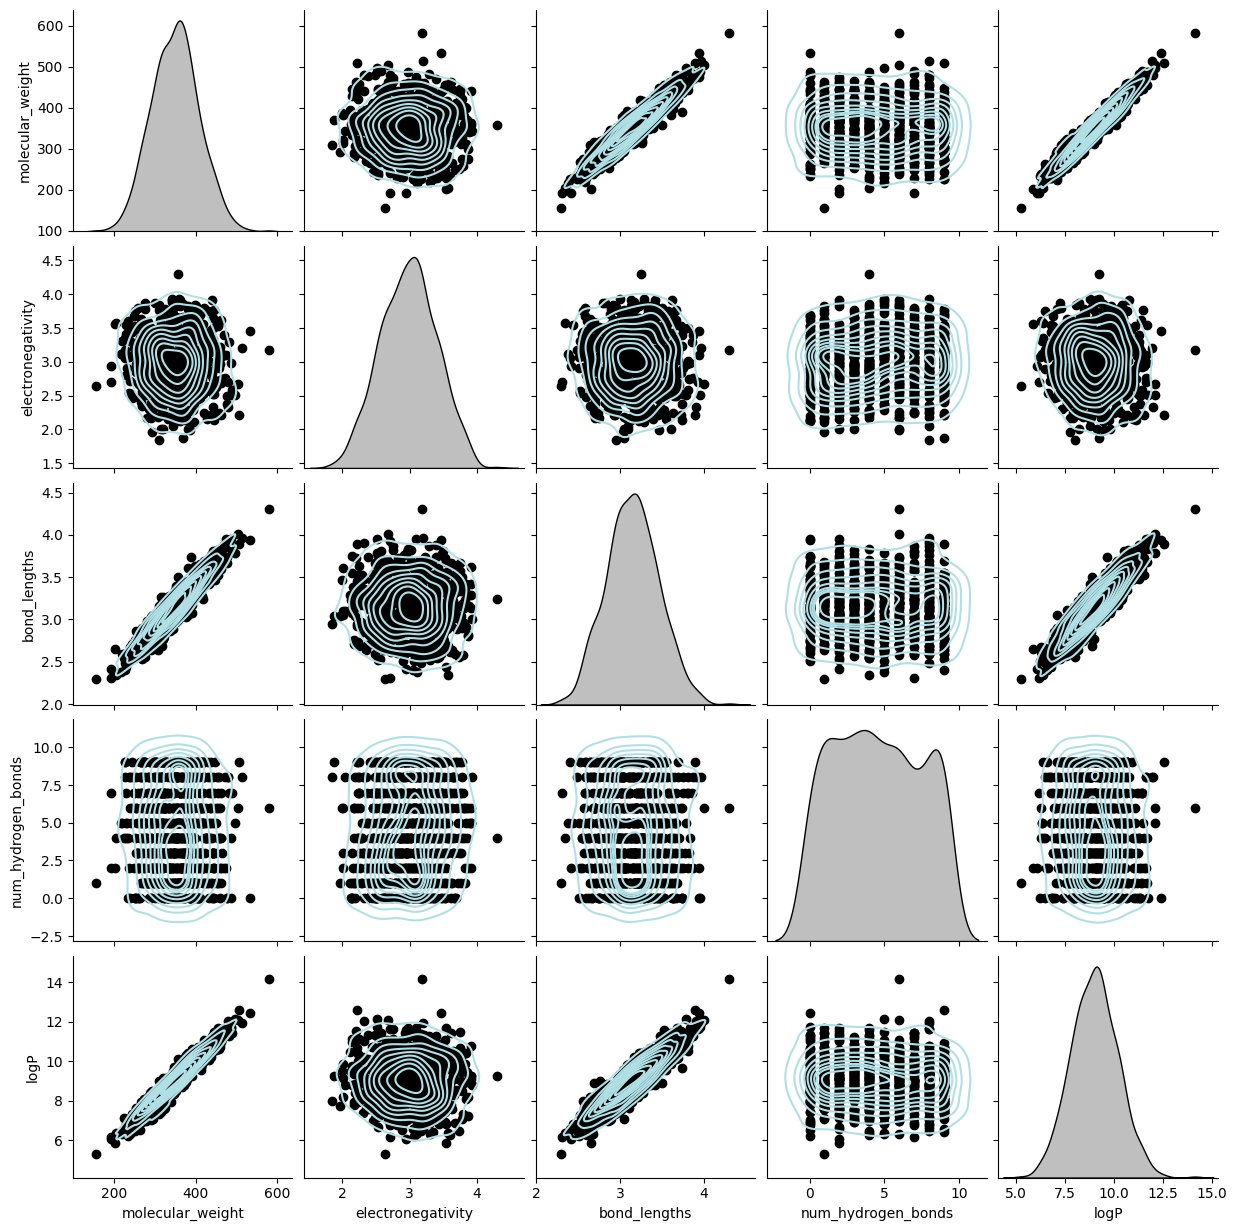

In [16]:
out = sns.pairplot(TrainX, kind = "kde", \
                   plot_kws = {'color':[176/255,224/255,230/255]}, \
                   diag_kws = {'color':'black'})
out.map_offdiag(plt.scatter, color = 'black')
plt.show()

As we can see, the features are highly correlated. Finally, we want to project the 5D dataset into 3D using UMAP (note, that this is no analysis yet).

2c) UMAP plot

In [18]:
TrainX_UMAP = umap.UMAP(n_components = 3).fit_transform(TrainX) #5D --> 3D

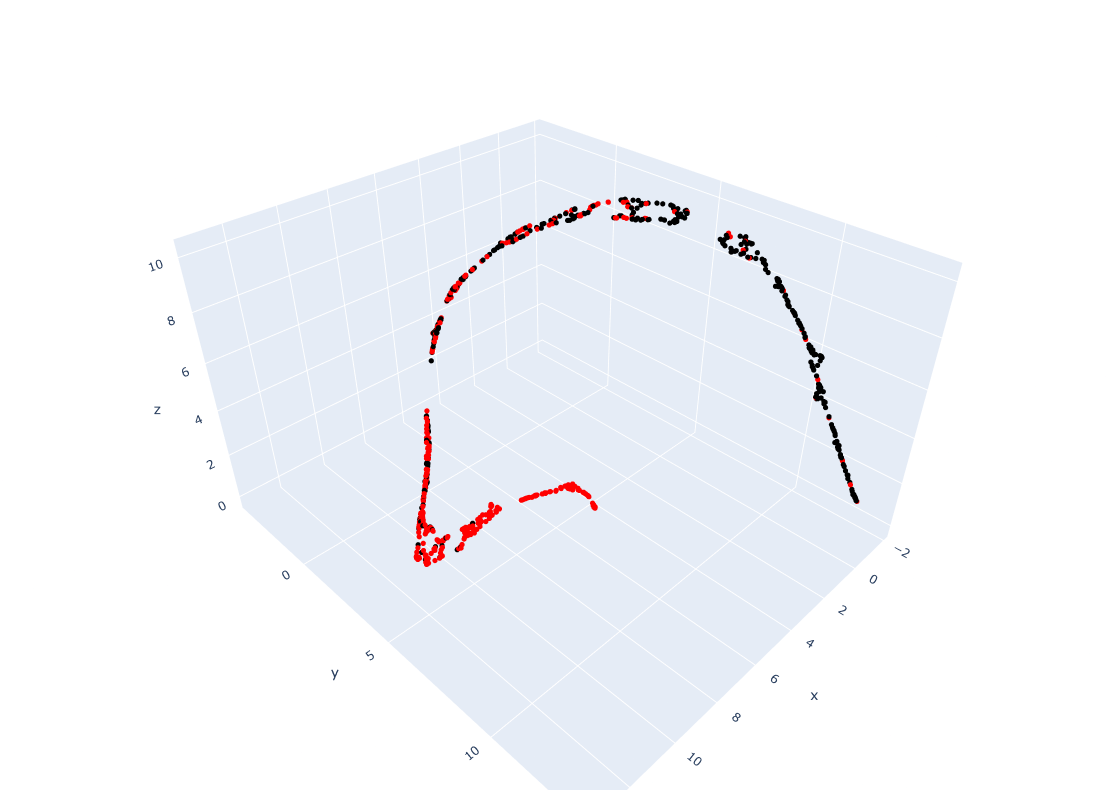

In [20]:
colorsIdx = {'Non-Toxic': 'black', 'Toxic': 'red'}
cols      = TrainY.map(colorsIdx)

scatter = go.Scatter3d(x = TrainX_UMAP[:,0], y = TrainX_UMAP[:,1], z = TrainX_UMAP[:,2], mode = 'markers', marker = dict(size = 3, color = cols))
fig     = go.Figure(data = [scatter])
fig.update_layout(width = 800, height = 800, margin = dict(r = 10, b = 10, l = 10, t = 10))
fig.show()

In the last plot, we can't really see cluster according to the labels. Therefore, let's scale the data and run a PCA

<br>

**3) Scaling & PCA**

Before performing any analysis, we have to scale the dataset.

3a) Scaling

In [22]:
All           = pd.concat((TrainX, TestX), axis = 0)
scaler        = MinMaxScaler(feature_range=(0, 1)) #mean = 0, std = 1
AllN          = scaler.fit_transform(All)

(rows, _)     = TrainX.shape
TrainXN       = pd.DataFrame(AllN[:rows,:])

3b) PCA

In [24]:
out = PCA(n_components = 5).fit(AllN)

eigenVec    = out.components_
eigenVal    = out.explained_variance_
eigenTrainX = out.transform(TrainXN)

Plotting eigenvalue spectrum:

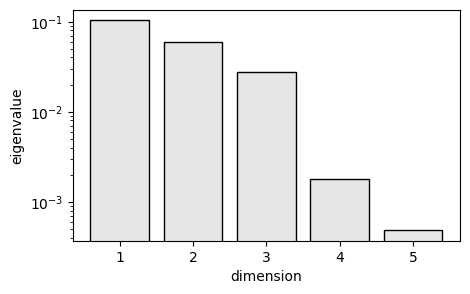

In [26]:
xplot    = np.arange(1,6)

fig = plt.figure(figsize=(5, 3))
plt.bar(xplot, eigenVal, color = (0.9, 0.9, 0.9), edgecolor = 'black')
plt.xlabel('dimension')
plt.ylabel('eigenvalue')
plt.yscale('log')
plt.xticks(xplot)
plt.show()

We see, that three features are sufficient in order to analyze the data, since two of the eigenvalues are significant smaller than the other three eigenvalues.<br>
Now, we first check the correlation heatmap and then create a plot of the scaled and PCA corrected data using UMAP.

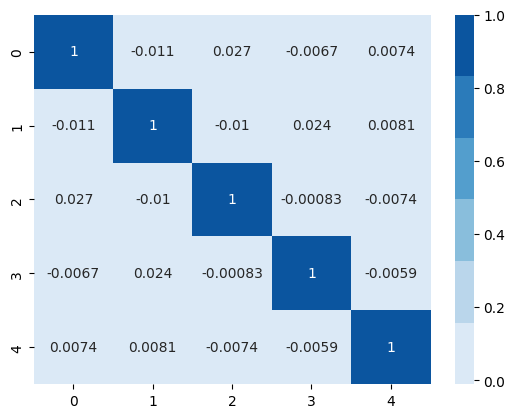

In [28]:
sns.heatmap(pd.DataFrame(eigenTrainX).corr(), annot=True, cmap = sns.color_palette("Blues"))
plt.show()

In [30]:
eigenXYZTrainX_UMAP = umap.UMAP(n_components = 3).fit_transform(eigenTrainX) #5D --> 3D

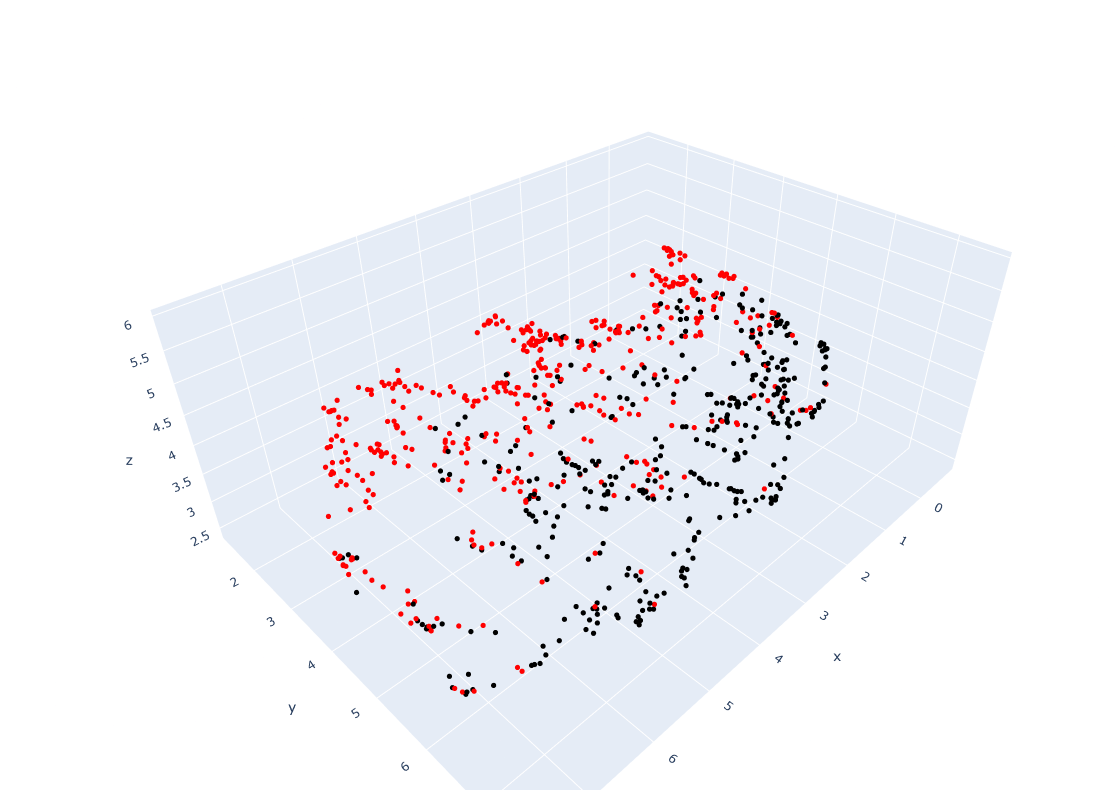

In [32]:
scatter = go.Scatter3d(x = eigenXYZTrainX_UMAP[:,0], y = eigenXYZTrainX_UMAP[:,1], z = eigenXYZTrainX_UMAP[:,2],
                       mode = 'markers', marker = dict(size = 3, color = cols))
fig     = go.Figure(data = [scatter])
fig.update_layout(width = 800, height = 800, margin = dict(r = 10, b = 10, l = 100, t = 10))
fig.show()

Eventough there are no well separated clusters visible, we at least find a tendency of the toxic molecules being on another part of the data space compared to to non-toxic molecules. 

<br>

**4) Naive Bayes**

We have scaled and de-correlated the data. In the next step, we can now apply naive Bayes and check the result using the test dataset.

In [34]:
TestXN      = pd.DataFrame(AllN[rows:,:]) #pulling normalized test dataset
eigenTestX  = out.transform(TestXN)       #performing PCA

In [44]:
gnb         = GaussianNB()
y_predGauss = gnb.fit(eigenTrainX, TrainY).predict(eigenTestX)

In [46]:
print("GaussianNB after PCA: Number of mislabelled points out of a total %d points : %d"
          % (TestX.shape[0], (TestY != y_predGauss).sum()))

GaussianNB after PCA: Number of mislabelled points out of a total 200 points : 35


The mislabelling ratio is about 15%. Let us compare that to the unscaled and correlated dataset

In [40]:
y_predGaussU = gnb.fit(TrainX, TrainY).predict(TestX)

In [42]:
print("GaussianNB after PCA: Number of mislabelled points out of a total %d points : %d"
          % (TestX.shape[0], (TestY != y_predGaussU).sum()))

GaussianNB after PCA: Number of mislabelled points out of a total 200 points : 38


Indeed, the performance is slightly worse.